In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import random
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class SVHNAugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', download=True,
                 max_rotation=15, min_crop_size=16, max_aspect_ratio_change=0.1, train=True):
        self.dataset = SVHN(root=root, split=split, download=download) # load the dataset
        self.train = train # to control the train and test
        
        self.augment = A.Compose([ # when in train mode, do the augmentation
            A.Rotate(limit=max_rotation, p=0.5),
            A.RandomResizedCrop(height=32, width=32, scale=(min_crop_size/32, 1.0), ratio=(1-max_aspect_ratio_change, 1+max_aspect_ratio_change), p=0.5),
            A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
            ToTensorV2()
        ])
        
        self.normalize = A.Compose([ # when in test mode, only do normalization
            A.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]),
            ToTensorV2()
        ])
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)

        if self.train:
            augmented = self.augment(image=image)
        else:
            augmented = self.normalize(image=image)
        
        image = augmented['image']
        return image, label

# load and transform the dataset
train_dataset = SVHNAugmentedDataset(root='./data', split='train', download=True, train=True)
test_dataset = SVHNAugmentedDataset(root='./data', split='test', download=True, train=False)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


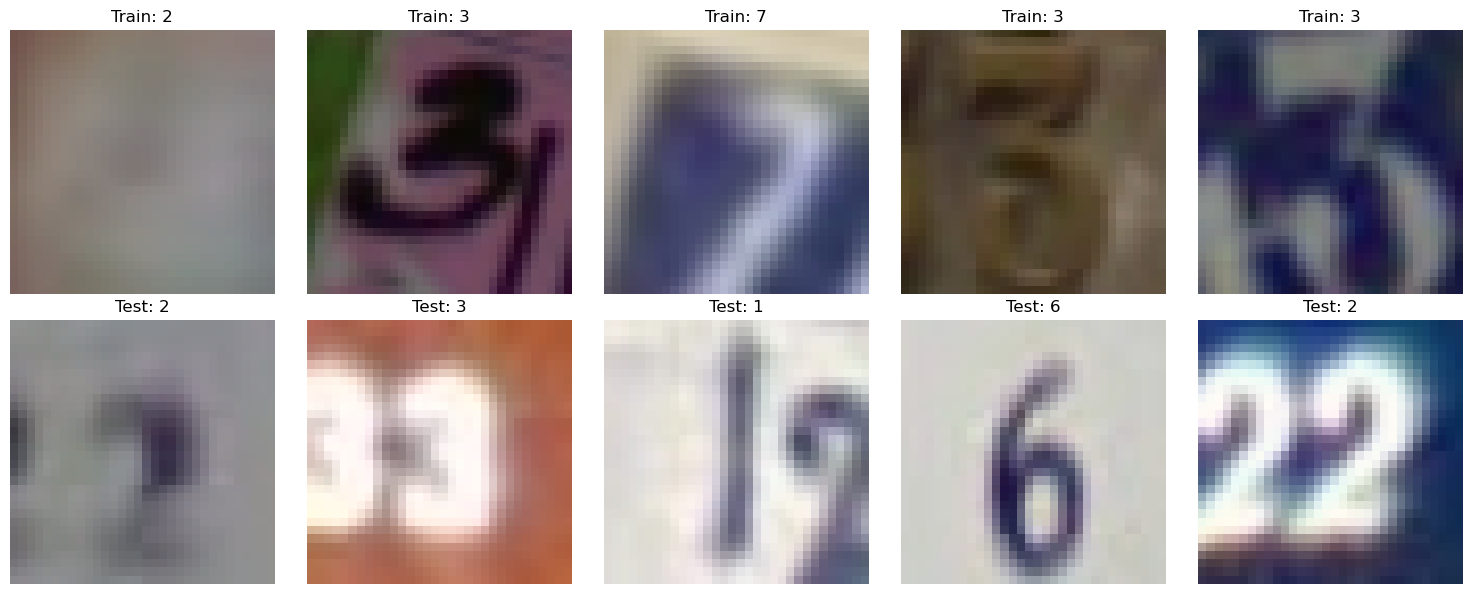

In [3]:
#to check the effect of the augmentation
random.seed(1008) # choose a random seed

#random select five images from both train and test
train_indices = random.sample(range(len(train_dataset)), 5)
test_indices = random.sample(range(len(test_dataset)), 5)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# show train image
for i, idx in enumerate(train_indices):
    train_image, train_label = train_dataset[idx]
    train_image = train_image.permute(1, 2, 0).numpy()
    train_image = (train_image * 0.1980 + 0.4377)  # inverse the normalization
    axes[0, i].imshow(train_image)
    axes[0, i].set_title(f"Train: {train_label}")
    axes[0, i].axis('off')

# show test image
for i, idx in enumerate(test_indices):
    test_image, test_label = test_dataset[idx]
    test_image = test_image.permute(1, 2, 0).numpy()
    test_image = (test_image * 0.1980 + 0.4377)  # inverse the normalization
    axes[1, i].imshow(test_image)
    axes[1, i].set_title(f"Test: {test_label}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
class SmallVGG(nn.Module):
    def __init__(self):
        super(SmallVGG, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.GroupNorm(2, 8), nn.ReLU(), 
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.GroupNorm(4, 16), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.GroupNorm(8, 32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.GroupNorm(8, 32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.GroupNorm(8, 32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.GroupNorm(8, 32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.25)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 4 * 4, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10) #output layer 10 classes
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x



In [5]:
def plot_graphs(y_true, y_scores, output_file):
    n_classes = y_true.max() + 1
    fpr = {}
    tpr = {}
    roc_auc = {}

    y_true_one_hot = np.eye(n_classes)[y_true]  # One-hot encode the true labels

    fig, axs = plt.subplots(2, 2, figsize=(16, 8))  # Create one plot for ROC curves and the other for losses and accuracies

    # ROC curve for ten classes
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        axs[0, 0].plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.4f})')

    # Micro ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_true_one_hot.ravel(), y_scores.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    axs[0, 1].plot(fpr_micro, tpr_micro, color='blue', lw=2, label=f'Micro ROC curve (area = {roc_auc_micro:.4f})')

    # Macro ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    roc_auc_macro = auc(mean_fpr, mean_tpr)
    axs[0, 1].plot(mean_fpr, mean_tpr, color='red', lw=2, label=f'Macro ROC curve (area = {roc_auc_macro:.4f})')

    axs[0, 0].plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    axs[0, 0].set_xlim([0.0, 1.0])
    axs[0, 0].set_ylim([0.0, 1.1])
    axs[0, 0].set_xlabel('False Positive Rate')
    axs[0, 0].set_ylabel('True Positive Rate')
    axs[0, 0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0, 0].legend(loc='lower right')

    axs[0, 1].plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    axs[0, 1].set_xlim([0.0, 1.0])
    axs[0, 1].set_ylim([0.0, 1.1])
    axs[0, 1].set_xlabel('False Positive Rate')
    axs[0, 1].set_ylabel('True Positive Rate')
    axs[0, 1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0, 1].legend(loc='lower right')

    axs[1, 0].plot(train_losses, label="Training Loss", color='blue')
    axs[1, 0].plot(test_losses, label="Testing Loss", color='orange')
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].set_title("Training and Testing Loss Curves")
    axs[1, 0].legend(loc='upper left')

    ax2 = axs[1, 0].twinx()
    ax2.plot(test_accuracies, label="Testing Accuracy", color='green', linestyle='--')
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='upper right')

    class_report = classification_report(y_true, np.argmax(y_scores, axis=1), output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    bar_width = 0.2
    index = np.arange(n_classes)

    for i, metric in enumerate(metrics):
        values = [class_report[str(cls)][metric] for cls in range(n_classes)]
        axs[1, 1].bar(index + i * bar_width, values, bar_width, label=metric)

    axs[1, 1].set_xlabel('Classes')
    axs[1, 1].set_ylabel('Scores')
    axs[1, 1].set_title('Class-wise Performance Metrics')
    axs[1, 1].set_xticks(index + bar_width)
    axs[1, 1].set_xticklabels([f'Class {i}' for i in range(n_classes)])
    axs[1, 1].legend(loc='upper left')
    axs[1, 1].set_ylim(0, 1)

    plt.tight_layout()

    # Save the figure to the specified output file
    plt.savefig(output_file)
    print(f"Plots saved to {output_file}")

    plt.show()

In [6]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    test_accuracies = []
    all_labels = []
    all_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        # Evaluation loop
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.append(labels.cpu().numpy())
                all_scores.append(outputs.cpu().numpy())

        epoch_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Test Loss: {epoch_test_loss:.4f}, "
              f"Accuracy: {accuracy:.2f}%")

    # Convert lists to numpy arrays for ROC AUC computation
    all_labels = np.concatenate(all_labels)
    all_scores = np.concatenate(all_scores)

    return train_losses, test_losses, test_accuracies, all_labels, all_scores

100%|██████████| 1145/1145 [00:34<00:00, 32.82it/s]


Epoch [1/100] - Train Loss: 1.3353, Test Loss: 0.4891, Accuracy: 85.26%


100%|██████████| 1145/1145 [00:36<00:00, 31.80it/s]


Epoch [2/100] - Train Loss: 0.7207, Test Loss: 0.3708, Accuracy: 88.51%


100%|██████████| 1145/1145 [00:35<00:00, 32.02it/s]


Epoch [3/100] - Train Loss: 0.6133, Test Loss: 0.3135, Accuracy: 90.66%


100%|██████████| 1145/1145 [00:34<00:00, 33.20it/s]


Epoch [4/100] - Train Loss: 0.5479, Test Loss: 0.2879, Accuracy: 91.48%


100%|██████████| 1145/1145 [00:36<00:00, 31.75it/s]


Epoch [5/100] - Train Loss: 0.5146, Test Loss: 0.2544, Accuracy: 92.45%


100%|██████████| 1145/1145 [00:33<00:00, 33.82it/s]


Epoch [6/100] - Train Loss: 0.4867, Test Loss: 0.2495, Accuracy: 92.86%


100%|██████████| 1145/1145 [00:36<00:00, 31.59it/s]


Epoch [7/100] - Train Loss: 0.4667, Test Loss: 0.2442, Accuracy: 93.04%


100%|██████████| 1145/1145 [00:35<00:00, 32.45it/s]


Epoch [8/100] - Train Loss: 0.4482, Test Loss: 0.2312, Accuracy: 93.45%


100%|██████████| 1145/1145 [00:32<00:00, 34.86it/s]


Epoch [9/100] - Train Loss: 0.4350, Test Loss: 0.2207, Accuracy: 93.80%


100%|██████████| 1145/1145 [00:35<00:00, 32.64it/s]


Epoch [10/100] - Train Loss: 0.4225, Test Loss: 0.2155, Accuracy: 94.11%


100%|██████████| 1145/1145 [00:34<00:00, 32.79it/s]


Epoch [11/100] - Train Loss: 0.4152, Test Loss: 0.2221, Accuracy: 93.75%


100%|██████████| 1145/1145 [00:36<00:00, 31.32it/s]


Epoch [12/100] - Train Loss: 0.4091, Test Loss: 0.2075, Accuracy: 94.23%


100%|██████████| 1145/1145 [00:38<00:00, 29.57it/s]


Epoch [13/100] - Train Loss: 0.3961, Test Loss: 0.2068, Accuracy: 94.23%


100%|██████████| 1145/1145 [00:34<00:00, 33.25it/s]


Epoch [14/100] - Train Loss: 0.3926, Test Loss: 0.2055, Accuracy: 94.36%


100%|██████████| 1145/1145 [00:35<00:00, 32.52it/s]


Epoch [15/100] - Train Loss: 0.3885, Test Loss: 0.2040, Accuracy: 94.44%


100%|██████████| 1145/1145 [00:33<00:00, 34.02it/s]


Epoch [16/100] - Train Loss: 0.3844, Test Loss: 0.1940, Accuracy: 94.64%


100%|██████████| 1145/1145 [00:32<00:00, 34.76it/s]


Epoch [17/100] - Train Loss: 0.3793, Test Loss: 0.1933, Accuracy: 94.60%


100%|██████████| 1145/1145 [00:31<00:00, 36.57it/s]


Epoch [18/100] - Train Loss: 0.3724, Test Loss: 0.2004, Accuracy: 94.63%


100%|██████████| 1145/1145 [00:33<00:00, 34.36it/s]


Epoch [19/100] - Train Loss: 0.3726, Test Loss: 0.1887, Accuracy: 94.83%


100%|██████████| 1145/1145 [00:32<00:00, 34.75it/s]


Epoch [20/100] - Train Loss: 0.3612, Test Loss: 0.1943, Accuracy: 94.79%


100%|██████████| 1145/1145 [00:33<00:00, 34.60it/s]


Epoch [21/100] - Train Loss: 0.3640, Test Loss: 0.1932, Accuracy: 94.74%


100%|██████████| 1145/1145 [00:32<00:00, 35.60it/s]


Epoch [22/100] - Train Loss: 0.3581, Test Loss: 0.1894, Accuracy: 94.89%


100%|██████████| 1145/1145 [00:33<00:00, 34.25it/s]


Epoch [23/100] - Train Loss: 0.3542, Test Loss: 0.1933, Accuracy: 94.71%


100%|██████████| 1145/1145 [00:32<00:00, 34.72it/s]


Epoch [24/100] - Train Loss: 0.3479, Test Loss: 0.1766, Accuracy: 95.23%


100%|██████████| 1145/1145 [00:34<00:00, 32.75it/s]


Epoch [25/100] - Train Loss: 0.3492, Test Loss: 0.1735, Accuracy: 95.41%


100%|██████████| 1145/1145 [00:32<00:00, 35.04it/s]


Epoch [26/100] - Train Loss: 0.3475, Test Loss: 0.1772, Accuracy: 95.52%


100%|██████████| 1145/1145 [00:32<00:00, 35.13it/s]


Epoch [27/100] - Train Loss: 0.3464, Test Loss: 0.1850, Accuracy: 94.99%


100%|██████████| 1145/1145 [00:33<00:00, 34.37it/s]


Epoch [28/100] - Train Loss: 0.3447, Test Loss: 0.1845, Accuracy: 95.02%


100%|██████████| 1145/1145 [00:34<00:00, 33.21it/s]


Epoch [29/100] - Train Loss: 0.3398, Test Loss: 0.1857, Accuracy: 94.89%


100%|██████████| 1145/1145 [00:33<00:00, 34.24it/s]


Epoch [30/100] - Train Loss: 0.3374, Test Loss: 0.1890, Accuracy: 94.86%


100%|██████████| 1145/1145 [00:33<00:00, 34.34it/s]


Epoch [31/100] - Train Loss: 0.3351, Test Loss: 0.1799, Accuracy: 95.18%


100%|██████████| 1145/1145 [00:33<00:00, 34.16it/s]


Epoch [32/100] - Train Loss: 0.3330, Test Loss: 0.1913, Accuracy: 94.80%


100%|██████████| 1145/1145 [00:34<00:00, 33.54it/s]


Epoch [33/100] - Train Loss: 0.3341, Test Loss: 0.1854, Accuracy: 95.00%


100%|██████████| 1145/1145 [00:34<00:00, 33.06it/s]


Epoch [34/100] - Train Loss: 0.3357, Test Loss: 0.1862, Accuracy: 95.07%


100%|██████████| 1145/1145 [00:36<00:00, 31.38it/s]


Epoch [35/100] - Train Loss: 0.3298, Test Loss: 0.1917, Accuracy: 94.71%


100%|██████████| 1145/1145 [00:36<00:00, 31.50it/s]


Epoch [36/100] - Train Loss: 0.3303, Test Loss: 0.1749, Accuracy: 95.36%


100%|██████████| 1145/1145 [00:36<00:00, 31.30it/s]


Epoch [37/100] - Train Loss: 0.3280, Test Loss: 0.1787, Accuracy: 95.26%


100%|██████████| 1145/1145 [00:33<00:00, 33.81it/s]


Epoch [38/100] - Train Loss: 0.3275, Test Loss: 0.1762, Accuracy: 95.26%


100%|██████████| 1145/1145 [00:32<00:00, 34.85it/s]


Epoch [39/100] - Train Loss: 0.3253, Test Loss: 0.1743, Accuracy: 95.31%


100%|██████████| 1145/1145 [00:34<00:00, 33.33it/s]


Epoch [40/100] - Train Loss: 0.3227, Test Loss: 0.1889, Accuracy: 95.01%


100%|██████████| 1145/1145 [00:32<00:00, 34.86it/s]


Epoch [41/100] - Train Loss: 0.3239, Test Loss: 0.1744, Accuracy: 95.33%


100%|██████████| 1145/1145 [00:32<00:00, 35.56it/s]


Epoch [42/100] - Train Loss: 0.3184, Test Loss: 0.1731, Accuracy: 95.48%


100%|██████████| 1145/1145 [00:33<00:00, 34.27it/s]


Epoch [43/100] - Train Loss: 0.3159, Test Loss: 0.1695, Accuracy: 95.52%


100%|██████████| 1145/1145 [00:33<00:00, 34.64it/s]


Epoch [44/100] - Train Loss: 0.3164, Test Loss: 0.1714, Accuracy: 95.42%


100%|██████████| 1145/1145 [00:31<00:00, 36.74it/s]


Epoch [45/100] - Train Loss: 0.3140, Test Loss: 0.1725, Accuracy: 95.34%


100%|██████████| 1145/1145 [00:32<00:00, 35.34it/s]


Epoch [46/100] - Train Loss: 0.3131, Test Loss: 0.1787, Accuracy: 95.29%


100%|██████████| 1145/1145 [00:33<00:00, 33.95it/s]


Epoch [47/100] - Train Loss: 0.3143, Test Loss: 0.1776, Accuracy: 95.14%


100%|██████████| 1145/1145 [00:34<00:00, 33.62it/s]


Epoch [48/100] - Train Loss: 0.3103, Test Loss: 0.1736, Accuracy: 95.36%


100%|██████████| 1145/1145 [00:34<00:00, 32.98it/s]


Epoch [49/100] - Train Loss: 0.3127, Test Loss: 0.1739, Accuracy: 95.42%


100%|██████████| 1145/1145 [00:35<00:00, 32.47it/s]


Epoch [50/100] - Train Loss: 0.3103, Test Loss: 0.1807, Accuracy: 95.11%


100%|██████████| 1145/1145 [00:35<00:00, 32.48it/s]


Epoch [51/100] - Train Loss: 0.3096, Test Loss: 0.1678, Accuracy: 95.57%


100%|██████████| 1145/1145 [00:35<00:00, 32.43it/s]


Epoch [52/100] - Train Loss: 0.3092, Test Loss: 0.1706, Accuracy: 95.36%


100%|██████████| 1145/1145 [00:35<00:00, 32.39it/s]


Epoch [53/100] - Train Loss: 0.3074, Test Loss: 0.1737, Accuracy: 95.44%


100%|██████████| 1145/1145 [00:35<00:00, 32.52it/s]


Epoch [54/100] - Train Loss: 0.3083, Test Loss: 0.1666, Accuracy: 95.58%


100%|██████████| 1145/1145 [00:35<00:00, 31.90it/s]


Epoch [55/100] - Train Loss: 0.3100, Test Loss: 0.1701, Accuracy: 95.54%


100%|██████████| 1145/1145 [00:35<00:00, 32.39it/s]


Epoch [56/100] - Train Loss: 0.3029, Test Loss: 0.1711, Accuracy: 95.45%


100%|██████████| 1145/1145 [00:35<00:00, 32.41it/s]


Epoch [57/100] - Train Loss: 0.3028, Test Loss: 0.1759, Accuracy: 95.40%


100%|██████████| 1145/1145 [00:35<00:00, 32.22it/s]


Epoch [58/100] - Train Loss: 0.3055, Test Loss: 0.1692, Accuracy: 95.57%


100%|██████████| 1145/1145 [00:35<00:00, 32.39it/s]


Epoch [59/100] - Train Loss: 0.3035, Test Loss: 0.1677, Accuracy: 95.56%


100%|██████████| 1145/1145 [00:35<00:00, 32.56it/s]


Epoch [60/100] - Train Loss: 0.3045, Test Loss: 0.1643, Accuracy: 95.69%


100%|██████████| 1145/1145 [00:35<00:00, 32.15it/s]


Epoch [61/100] - Train Loss: 0.3009, Test Loss: 0.1657, Accuracy: 95.65%


100%|██████████| 1145/1145 [00:35<00:00, 32.25it/s]


Epoch [62/100] - Train Loss: 0.3032, Test Loss: 0.1651, Accuracy: 95.66%


100%|██████████| 1145/1145 [00:35<00:00, 32.37it/s]


Epoch [63/100] - Train Loss: 0.3061, Test Loss: 0.1681, Accuracy: 95.59%


100%|██████████| 1145/1145 [00:33<00:00, 34.02it/s]


Epoch [64/100] - Train Loss: 0.2994, Test Loss: 0.1627, Accuracy: 95.62%


100%|██████████| 1145/1145 [00:35<00:00, 32.43it/s]


Epoch [65/100] - Train Loss: 0.2987, Test Loss: 0.1673, Accuracy: 95.62%


100%|██████████| 1145/1145 [00:35<00:00, 32.42it/s]


Epoch [66/100] - Train Loss: 0.2975, Test Loss: 0.1672, Accuracy: 95.60%


100%|██████████| 1145/1145 [00:35<00:00, 32.36it/s]


Epoch [67/100] - Train Loss: 0.2968, Test Loss: 0.1594, Accuracy: 95.82%


100%|██████████| 1145/1145 [00:35<00:00, 32.24it/s]


Epoch [68/100] - Train Loss: 0.2947, Test Loss: 0.1651, Accuracy: 95.60%


100%|██████████| 1145/1145 [00:35<00:00, 32.15it/s]


Epoch [69/100] - Train Loss: 0.2991, Test Loss: 0.1619, Accuracy: 95.72%


100%|██████████| 1145/1145 [00:35<00:00, 32.04it/s]


Epoch [70/100] - Train Loss: 0.2952, Test Loss: 0.1711, Accuracy: 95.46%


100%|██████████| 1145/1145 [00:35<00:00, 32.03it/s]


Epoch [71/100] - Train Loss: 0.2953, Test Loss: 0.1576, Accuracy: 95.91%


100%|██████████| 1145/1145 [00:36<00:00, 31.24it/s]


Epoch [72/100] - Train Loss: 0.2957, Test Loss: 0.1712, Accuracy: 95.47%


100%|██████████| 1145/1145 [00:32<00:00, 35.31it/s]


Epoch [73/100] - Train Loss: 0.2950, Test Loss: 0.1679, Accuracy: 95.50%


100%|██████████| 1145/1145 [00:32<00:00, 35.60it/s]


Epoch [74/100] - Train Loss: 0.2924, Test Loss: 0.1710, Accuracy: 95.61%


100%|██████████| 1145/1145 [00:35<00:00, 32.38it/s]


Epoch [75/100] - Train Loss: 0.2934, Test Loss: 0.1625, Accuracy: 95.70%


100%|██████████| 1145/1145 [00:34<00:00, 33.10it/s]


Epoch [76/100] - Train Loss: 0.2932, Test Loss: 0.1637, Accuracy: 95.67%


100%|██████████| 1145/1145 [00:35<00:00, 32.51it/s]


Epoch [77/100] - Train Loss: 0.2941, Test Loss: 0.1749, Accuracy: 95.29%


100%|██████████| 1145/1145 [00:30<00:00, 36.94it/s]


Epoch [78/100] - Train Loss: 0.2938, Test Loss: 0.1621, Accuracy: 95.67%


100%|██████████| 1145/1145 [00:32<00:00, 35.20it/s]


Epoch [79/100] - Train Loss: 0.2888, Test Loss: 0.1666, Accuracy: 95.69%


100%|██████████| 1145/1145 [00:34<00:00, 33.18it/s]


Epoch [80/100] - Train Loss: 0.2909, Test Loss: 0.1615, Accuracy: 95.70%


100%|██████████| 1145/1145 [00:35<00:00, 31.86it/s]


Epoch [81/100] - Train Loss: 0.2898, Test Loss: 0.1675, Accuracy: 95.62%


100%|██████████| 1145/1145 [00:34<00:00, 32.72it/s]


Epoch [82/100] - Train Loss: 0.2869, Test Loss: 0.1667, Accuracy: 95.55%


100%|██████████| 1145/1145 [00:35<00:00, 32.40it/s]


Epoch [83/100] - Train Loss: 0.2901, Test Loss: 0.1625, Accuracy: 95.71%


100%|██████████| 1145/1145 [00:35<00:00, 32.44it/s]


Epoch [84/100] - Train Loss: 0.2881, Test Loss: 0.1627, Accuracy: 95.66%


100%|██████████| 1145/1145 [00:35<00:00, 32.67it/s]


Epoch [85/100] - Train Loss: 0.2927, Test Loss: 0.1589, Accuracy: 95.79%


100%|██████████| 1145/1145 [00:32<00:00, 35.27it/s]


Epoch [86/100] - Train Loss: 0.2823, Test Loss: 0.1609, Accuracy: 95.76%


100%|██████████| 1145/1145 [00:35<00:00, 32.01it/s]


Epoch [87/100] - Train Loss: 0.2863, Test Loss: 0.1609, Accuracy: 95.78%


100%|██████████| 1145/1145 [00:34<00:00, 33.44it/s]


Epoch [88/100] - Train Loss: 0.2896, Test Loss: 0.1644, Accuracy: 95.66%


100%|██████████| 1145/1145 [00:32<00:00, 34.91it/s]


Epoch [89/100] - Train Loss: 0.2859, Test Loss: 0.1659, Accuracy: 95.69%


100%|██████████| 1145/1145 [00:33<00:00, 34.22it/s]


Epoch [90/100] - Train Loss: 0.2875, Test Loss: 0.1669, Accuracy: 95.61%


100%|██████████| 1145/1145 [00:33<00:00, 34.49it/s]


Epoch [91/100] - Train Loss: 0.2876, Test Loss: 0.1645, Accuracy: 95.61%


100%|██████████| 1145/1145 [00:34<00:00, 32.89it/s]


Epoch [92/100] - Train Loss: 0.2817, Test Loss: 0.1564, Accuracy: 95.81%


100%|██████████| 1145/1145 [00:32<00:00, 34.98it/s]


Epoch [93/100] - Train Loss: 0.2820, Test Loss: 0.1625, Accuracy: 95.91%


100%|██████████| 1145/1145 [00:33<00:00, 33.77it/s]


Epoch [94/100] - Train Loss: 0.2835, Test Loss: 0.1610, Accuracy: 95.69%


100%|██████████| 1145/1145 [00:34<00:00, 33.34it/s]


Epoch [95/100] - Train Loss: 0.2833, Test Loss: 0.1692, Accuracy: 95.56%


100%|██████████| 1145/1145 [00:32<00:00, 34.78it/s]


Epoch [96/100] - Train Loss: 0.2843, Test Loss: 0.1575, Accuracy: 95.86%


100%|██████████| 1145/1145 [00:35<00:00, 31.94it/s]


Epoch [97/100] - Train Loss: 0.2875, Test Loss: 0.1658, Accuracy: 95.57%


100%|██████████| 1145/1145 [00:34<00:00, 33.63it/s]


Epoch [98/100] - Train Loss: 0.2827, Test Loss: 0.1559, Accuracy: 95.84%


100%|██████████| 1145/1145 [00:35<00:00, 32.71it/s]


Epoch [99/100] - Train Loss: 0.2830, Test Loss: 0.1683, Accuracy: 95.56%


100%|██████████| 1145/1145 [00:35<00:00, 32.68it/s]


Epoch [100/100] - Train Loss: 0.2837, Test Loss: 0.1559, Accuracy: 95.83%
Plots saved to C:/Users/Administrator/Desktop/GitHub-2024/CISC3024_New/Record\Final.png


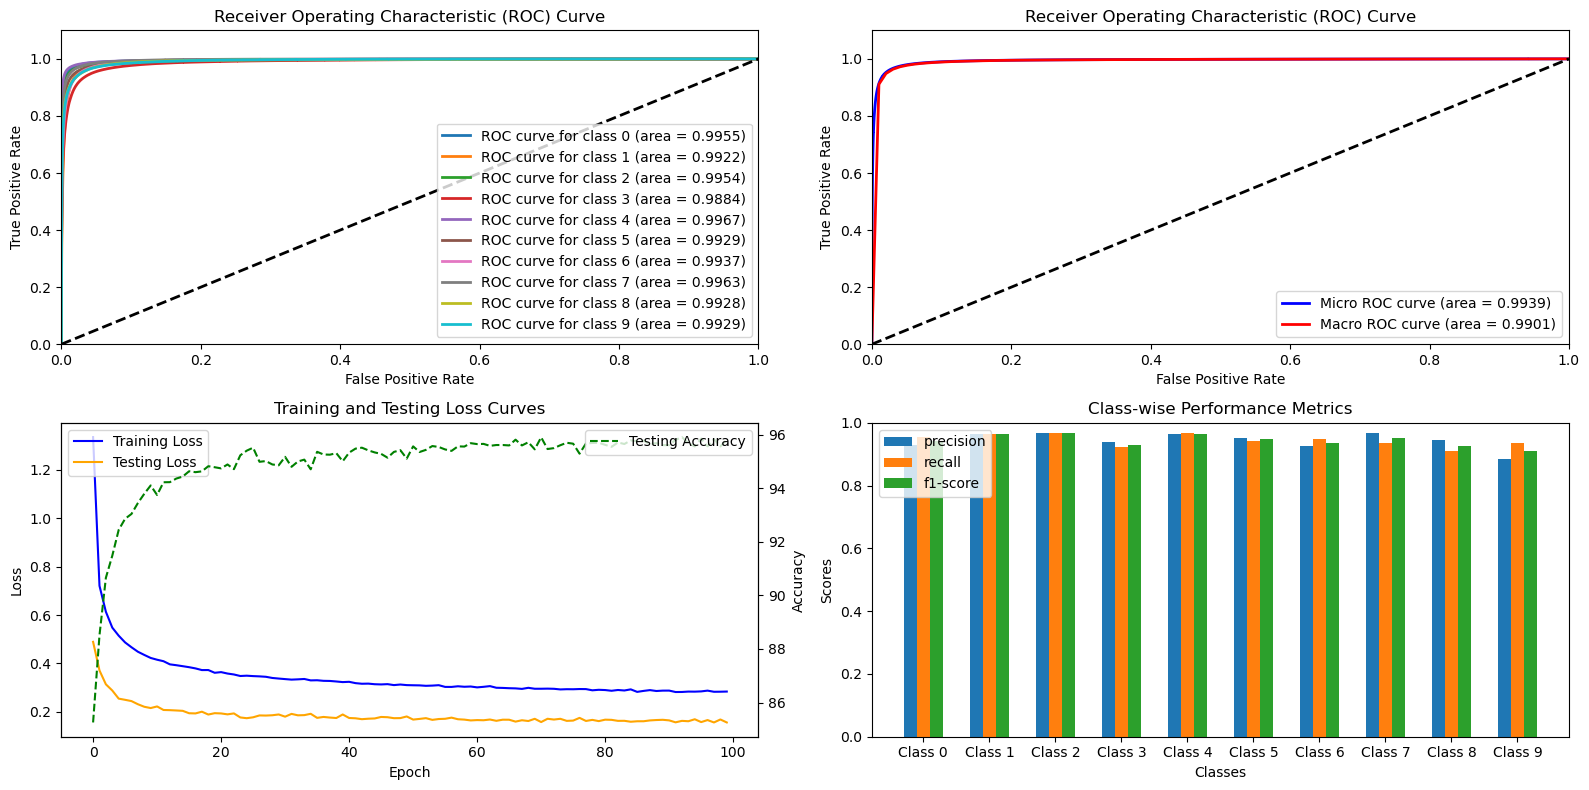

In [7]:
model = SmallVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #learning rate
# Example usage
num_epochs = 100
train_losses, test_losses, test_accuracies, all_labels, all_scores = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)

# Define your output path and filename
output_dir = 'C:/Users/Administrator/Desktop/GitHub-2024/CISC3024_New/Record'  # Update this path according to your system
output_filename = 'Final.png'  # Specify your desired filename

output_file = os.path.join(output_dir, output_filename)
os.makedirs(output_dir, exist_ok=True)

plot_graphs(all_labels, all_scores, output_file=output_file)

In [8]:
torch.save(model.state_dict(), 'model.pth')